# XGBoost - Teste 2024

C:\Users\rossa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


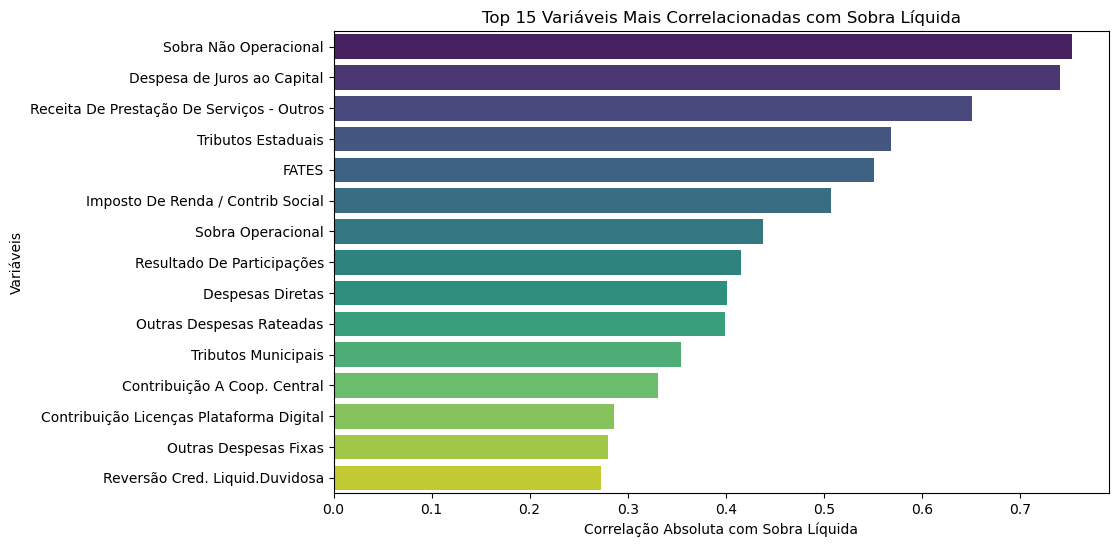

Otimizando hiperparâmetros:  25%|█████████████▎                                       | 25/100 [00:00<00:01, 64.42it/s]

Melhor erro até agora: 18944088041363.496 na trial 0


Otimizando hiperparâmetros:  50%|██████████████████████████▌                          | 50/100 [00:09<00:10,  4.62it/s]

Melhor erro até agora: 5940958588822.77 na trial 1


Otimizando hiperparâmetros:  75%|███████████████████████████████████████▊             | 75/100 [00:20<00:08,  3.08it/s]

Melhor erro até agora: 5795532662027.47 na trial 45


Otimizando hiperparâmetros: 100%|████████████████████████████████████████████████████| 100/100 [00:41<00:00,  1.93it/s]

Melhor erro até agora: 4942128781226.965 na trial 71


Otimizando hiperparâmetros: 100%|████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


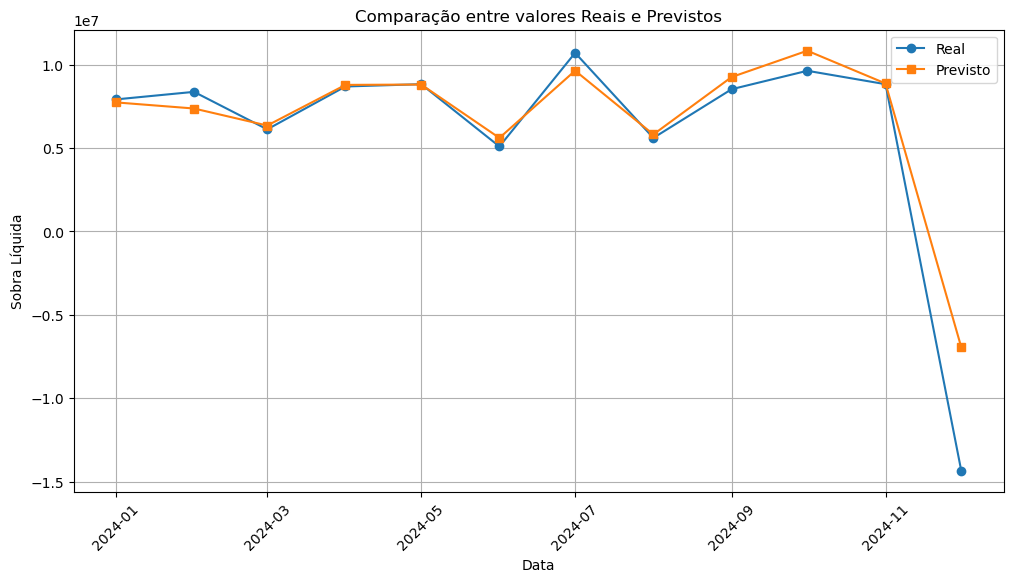

Mean Squared Error: 4942128781226.965
Mean Absolute Error: 1057229.7624999997
R² Score: 0.8785967458261243
Melhores hiperparâmetros encontrados pelo Optuna:
{'n_estimators': 1993, 'learning_rate': 0.003435534009262996, 'max_depth': 13, 'subsample': 0.5060072455718684, 'colsample_bytree': 0.946402950566432, 'reg_alpha': 0.0032086177126932646, 'reg_lambda': 0.04541099181142888, 'min_child_weight': 1, 'gamma': 3.0952860917333123}


In [31]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import logging

# Configurar logging do Optuna para reduzir a frequência das mensagens
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Carregar os dados do arquivo Excel
file_path = r"C:\Users\rossa\Desktop\Previsão\Teste.xlsx"
data = pd.read_excel(file_path, engine='openpyxl')

# Remover espaços extras dos nomes das colunas
data.columns = data.columns.str.strip()

# Calcular a correlação entre 'Sobra Líquida' e as demais colunas
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['Sobra Líquida'].abs().sort_values(ascending=False)
top_15_variables = correlation_with_target.index[1:16].tolist()  # Pega as 15 variáveis mais correlacionadas

# Plotar gráfico de correlação
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target[top_15_variables], y=top_15_variables, palette="viridis")
plt.xlabel("Correlação Absoluta com Sobra Líquida")
plt.ylabel("Variáveis")
plt.title("Top 15 Variáveis Mais Correlacionadas com Sobra Líquida")
plt.show()

# Selecionar as 15 variáveis mais correlacionadas
selected_columns = ['Ano', 'Mês'] + top_15_variables

# Criar novo dataframe com as variáveis selecionadas
filtered_data = data[selected_columns + ['Sobra Líquida']].copy()

# Criar novas features baseadas no tempo
filtered_data['Date'] = pd.to_datetime(filtered_data['Ano'].astype(str) + '-' + filtered_data['Mês'].astype(str) + '-01')
filtered_data.set_index('Date', inplace=True)
filtered_data['Quarter'] = filtered_data.index.quarter
filtered_data['Month_Sin'] = np.sin(2 * np.pi * filtered_data.index.month / 12)
filtered_data['Month_Cos'] = np.cos(2 * np.pi * filtered_data.index.month / 12)
filtered_data['Sobra_Liquida_3M_Moving_Avg'] = filtered_data['Sobra Líquida'].rolling(window=3).mean()
filtered_data['Sobra_Liquida_6M_Moving_Avg'] = filtered_data['Sobra Líquida'].rolling(window=6).mean()
filtered_data['Sobra_Liquida_Monthly_Diff'] = filtered_data['Sobra Líquida'].diff()

# Adicionar médias móveis e diferenças mensais para as variáveis selecionadas
for col in selected_columns[2:]:
    filtered_data[f'{col}_Moving_Avg'] = filtered_data[col].rolling(window=3).mean()
    filtered_data[f'{col}_Diff'] = filtered_data[col].diff()

# Preencher valores NaN
filtered_data.fillna(0, inplace=True)

# Separar em treino (<= 2023) e teste (2024)
train_data = filtered_data[filtered_data.index.year <= 2023]
test_data = filtered_data[filtered_data.index.year == 2024]

# Preparar as características e variável alvo
X_train = train_data.drop(columns=['Sobra Líquida'])
y_train = train_data['Sobra Líquida']
X_test = test_data.drop(columns=['Sobra Líquida'])
y_test = test_data['Sobra Líquida']

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5)
    }

    model = XGBRegressor(**param_grid, objective='reg:squarederror', random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return mean_squared_error(y_test, y_pred)

# Otimização com Optuna e barra de progresso
n_trials=100
study = optuna.create_study(direction='minimize')
with tqdm(total=n_trials, desc="Otimizando hiperparâmetros") as pbar:
    def callback(study, trial):
        if trial.number % 25 == 0:
            pbar.update(25)
            print(f"Melhor erro até agora: {study.best_value} na trial {study.best_trial.number}")
    study.optimize(objective, n_trials, callbacks=[callback])

# Treinar modelo otimizado
best_params = study.best_params
best_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train_scaled, y_train)

y_pred = best_model.predict(X_test_scaled)

# Calcular métricas de erro
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

diff_percentage = ((y_test - y_pred) / y_pred) * 100

results_df = pd.DataFrame({
    'Date': X_test.index,
    'Actual': y_test,
    'Predicted': y_pred,
    'Difference (%)': diff_percentage
})

results_df.to_excel(r"C:\Users\rossa\Desktop\Previsão\Previsão2024-Cor.xlsx", index=False)

# Gerar gráfico comparando real vs previsto
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Real', marker='o')
plt.plot(results_df['Date'], results_df['Predicted'], label='Previsto', marker='s')
plt.xlabel("Data")
plt.ylabel("Sobra Líquida")
plt.title("Comparação entre valores Reais e Previstos")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")
print("Melhores hiperparâmetros encontrados pelo Optuna:")
print(best_params)


# XGBoost - Prevendo 2025

C:\Users\rossa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


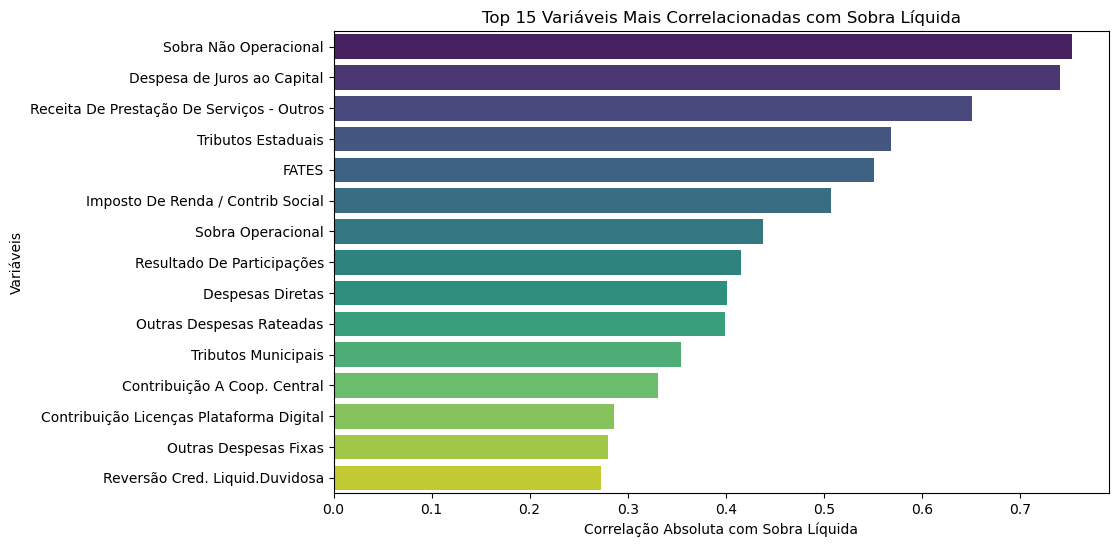

Otimizando Sobra Líquida:  50%|███████████████████████████▌                           | 25/50 [00:00<00:00, 217.94it/s]

Sobra Líquida: Melhor erro até agora: 0.60 na trial 0


Otimizando Sobra Líquida:  50%|████████████████████████████                            | 25/50 [00:01<00:01, 14.11it/s]


Previsão para 2025 concluída e salva.


In [57]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import logging

# Configurar logging do Optuna para reduzir a frequência das mensagens
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Carregar os dados do arquivo Excel
file_path = r"C:\Users\rossa\Desktop\Previsão\Teste.xlsx"
data = pd.read_excel(file_path, engine='openpyxl')

# Remover espaços extras dos nomes das colunas
data.columns = data.columns.str.strip()

# Calcular a correlação entre 'Sobra Líquida' e as demais colunas
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['Sobra Líquida'].abs().sort_values(ascending=False)
top_15_variables = correlation_with_target.index[1:16].tolist()  # Pega as 15 variáveis mais correlacionadas

# Plotar gráfico de correlação
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target[top_15_variables], y=top_15_variables, palette="viridis")
plt.xlabel("Correlação Absoluta com Sobra Líquida")
plt.ylabel("Variáveis")
plt.title("Top 15 Variáveis Mais Correlacionadas com Sobra Líquida")
plt.show()

# Selecionar as 15 variáveis mais correlacionadas
selected_columns = ['Ano', 'Mês'] + top_15_variables

# Criar novo dataframe com as variáveis selecionadas
filtered_data = data[selected_columns + ['Sobra Líquida']].copy()

# Criar novas features baseadas no tempo
filtered_data['Date'] = pd.to_datetime(filtered_data['Ano'].astype(str) + '-' + filtered_data['Mês'].astype(str) + '-01')
filtered_data.set_index('Date', inplace=True)
filtered_data['Quarter'] = filtered_data.index.quarter
filtered_data['Month_Sin'] = np.sin(2 * np.pi * filtered_data.index.month / 12)
filtered_data['Month_Cos'] = np.cos(2 * np.pi * filtered_data.index.month / 12)

# Preencher valores NaN
filtered_data.fillna(0, inplace=True)

# Atualizar conjunto de treinamento para incluir dados de 2024
train_data = filtered_data.copy()

# Criar datas futuras para previsão de 2025
future_dates = pd.date_range(start='2025-01-01', end='2025-12-01', freq='MS')
future_df = pd.DataFrame({'Date': future_dates})
future_df['Ano'] = future_df['Date'].dt.year
future_df['Mês'] = future_df['Date'].dt.month
future_df['Quarter'] = future_df['Date'].dt.quarter
future_df['Month_Sin'] = np.sin(2 * np.pi * future_df['Mês'] / 12)
future_df['Month_Cos'] = np.cos(2 * np.pi * future_df['Mês'] / 12)

# Função para otimizar hiperparâmetros com Optuna
def optimize_variable(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = XGBRegressor(**params, objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    return mean_squared_error(y_train, y_pred)

# Prever valores das 15 variáveis correlacionadas para 2025 com barra de progresso
with tqdm(total=len(top_15_variables), desc="Prevendo variáveis correlacionadas") as pbar:
    for col in top_15_variables:
        X_train_var = train_data[['Ano', 'Mês', 'Quarter', 'Month_Sin', 'Month_Cos']]
        y_train_var = train_data[col]
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: optimize_variable(trial, X_train_var, y_train_var), n_trials=10)
        best_params = study.best_params
        best_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
        best_model.fit(X_train_var, y_train_var)
        future_df[col] = best_model.predict(future_df[['Ano', 'Mês', 'Quarter', 'Month_Sin', 'Month_Cos']])
        pbar.update(1)

# Criar médias móveis e diferenças após prever variáveis
for col in top_15_variables:
    future_df[f'{col}_Moving_Avg'] = future_df[col].rolling(window=3).mean()
    future_df[f'{col}_Diff'] = future_df[col].diff()

# Preencher valores NaN
future_df.fillna(0, inplace=True)

# Criar conjunto final para prever 'Sobra Líquida' em 2025
X_train_final = train_data.drop(columns=['Sobra Líquida'])
y_train_final = train_data['Sobra Líquida']

# Normalizar os dados
scaler = StandardScaler()
X_train_final_scaled = scaler.fit_transform(X_train_final)

# Garantir que future_df tenha as mesmas colunas antes da normalização
future_df = future_df[X_train_final.columns]
X_future_scaled = scaler.transform(future_df)

# Otimizar hiperparâmetros para prever 'Sobra Líquida' com Optuna e barra de progresso
with tqdm(total=50, desc="Otimizando Sobra Líquida") as pbar:
    def callback(study, trial):
        if trial.number % 25 == 0:
            pbar.update(25)
            print(f"Sobra Líquida: Melhor erro até agora: {study.best_value:.2f} na trial {study.best_trial.number}")
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: optimize_variable(trial, X_train_final_scaled, y_train_final), n_trials=10, callbacks=[callback])

best_params = study.best_params
best_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train_final_scaled, y_train_final)

y_future_pred = best_model.predict(X_future_scaled)
future_df['Predicted_Sobra_Liquida'] = y_future_pred

# Salvar previsões de 2025
future_df.to_excel(r"C:\Users\rossa\Desktop\Previsão\Previsao2025-cor.xlsx", index=False)

print("Previsão para 2025 concluída e salva.")


# Prophet

C:\Users\rossa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


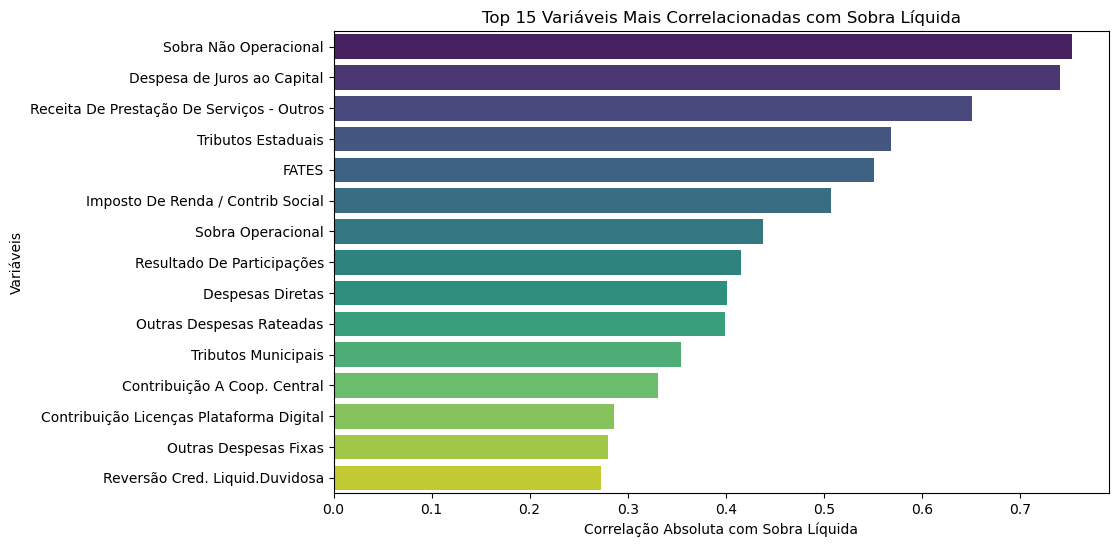

21:51:39 - cmdstanpy - INFO - Chain [1] start processing
21:52:23 - cmdstanpy - INFO - Chain [1] done processing


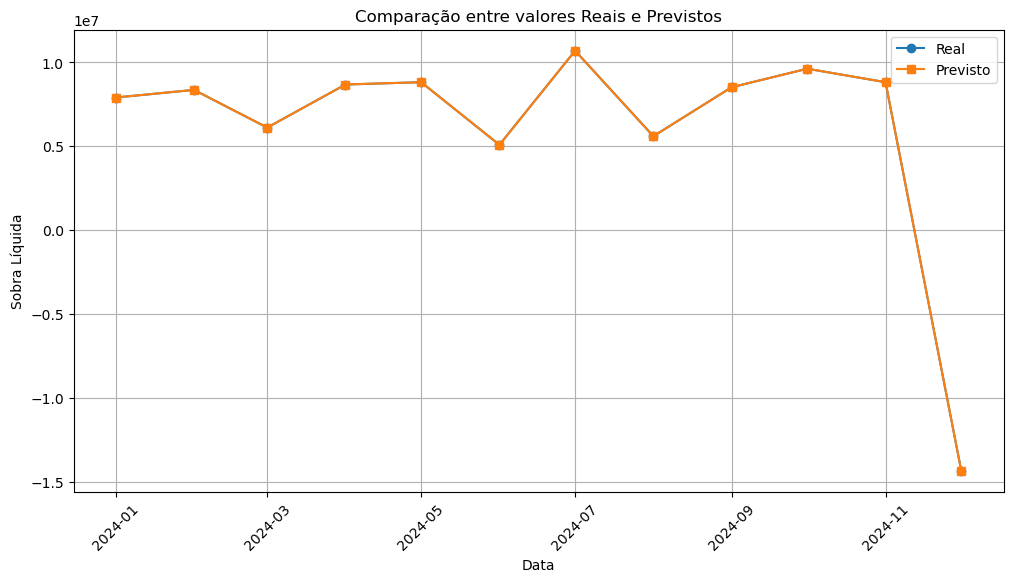

Mean Squared Error: 948043.0145082107
Mean Absolute Error: 863.2322684884226
R² Score: 0.9999999767113501


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from tqdm import tqdm

# Carregar os dados do arquivo Excel
file_path = r"C:\Users\rossa\Desktop\Previsão\Teste.xlsx"
data = pd.read_excel(file_path, engine='openpyxl')

# Remover espaços extras dos nomes das colunas
data.columns = data.columns.str.strip()

# Calcular a correlação entre 'Sobra Líquida' e as demais colunas
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['Sobra Líquida'].abs().sort_values(ascending=False)
top_15_variables = correlation_with_target.index[1:16].tolist()

# Plotar gráfico de correlação
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target[top_15_variables], y=top_15_variables, palette="viridis")
plt.xlabel("Correlação Absoluta com Sobra Líquida")
plt.ylabel("Variáveis")
plt.title("Top 15 Variáveis Mais Correlacionadas com Sobra Líquida")
plt.show()

# Selecionar as 15 variáveis mais correlacionadas
selected_columns = ['Ano', 'Mês'] + top_15_variables

# Criar novo dataframe com as variáveis selecionadas
filtered_data = data[selected_columns + ['Sobra Líquida']].copy()

# Criar novas features baseadas no tempo
filtered_data['Date'] = pd.to_datetime(filtered_data['Ano'].astype(str) + '-' + filtered_data['Mês'].astype(str) + '-01')
filtered_data.set_index('Date', inplace=True)
filtered_data['Quarter'] = filtered_data.index.quarter
filtered_data['Month_Sin'] = np.sin(2 * np.pi * filtered_data.index.month / 12)
filtered_data['Month_Cos'] = np.cos(2 * np.pi * filtered_data.index.month / 12)
filtered_data['Sobra_Liquida_3M_Moving_Avg'] = filtered_data['Sobra Líquida'].rolling(window=3).mean()
filtered_data['Sobra_Liquida_6M_Moving_Avg'] = filtered_data['Sobra Líquida'].rolling(window=6).mean()
filtered_data['Sobra_Liquida_Monthly_Diff'] = filtered_data['Sobra Líquida'].diff()

# Adicionar médias móveis e diferenças mensais para as variáveis selecionadas
for col in selected_columns[2:]:
    filtered_data[f'{col}_Moving_Avg'] = filtered_data[col].rolling(window=3).mean()
    filtered_data[f'{col}_Diff'] = filtered_data[col].diff()

# Preencher valores NaN
filtered_data.fillna(0, inplace=True)

# Separar em treino (<= 2023) e teste (2024)
train_data = filtered_data[filtered_data.index.year <= 2023]
test_data = filtered_data[filtered_data.index.year == 2024]

# Criar conjunto final para prever 'Sobra Líquida' em 2024
df_train_final = train_data[['Sobra Líquida'] + top_15_variables].reset_index()
df_train_final.columns = ['ds', 'y'] + top_15_variables

# Treinar modelo Prophet com variáveis adicionais
model = Prophet()
for regressor in top_15_variables:
    model.add_regressor(regressor)

model.fit(df_train_final)

# Preparar dados futuros
future = test_data[top_15_variables].reset_index()
future.columns = ['ds'] + top_15_variables
forecast = model.predict(future)
test_data = test_data.copy()
test_data.loc[:, 'Predicted_Sobra_Liquida'] = forecast['yhat'].values

# Calcular métricas de erro
mse = np.mean((test_data['Sobra Líquida'] - test_data['Predicted_Sobra_Liquida']) ** 2)
mae = np.mean(abs(test_data['Sobra Líquida'] - test_data['Predicted_Sobra_Liquida']))
r2 = 1 - (np.sum((test_data['Sobra Líquida'] - test_data['Predicted_Sobra_Liquida']) ** 2) / np.sum((test_data['Sobra Líquida'] - np.mean(test_data['Sobra Líquida'])) ** 2))

diff_percentage = ((test_data['Sobra Líquida'] - test_data['Predicted_Sobra_Liquida']) / test_data['Predicted_Sobra_Liquida']) * 100

results_df = pd.DataFrame({
    'Date': test_data.index,
    'Actual': test_data['Sobra Líquida'],
    'Predicted': test_data['Predicted_Sobra_Liquida'],
    'Difference (%)': diff_percentage
})

results_df.to_excel(r"C:\Users\rossa\Desktop\Previsão\Previsão2024-Prophet.xlsx", index=False)

# Gerar gráfico comparando real vs previsto
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Real', marker='o')
plt.plot(results_df['Date'], results_df['Predicted'], label='Previsto', marker='s')
plt.xlabel("Data")
plt.ylabel("Sobra Líquida")
plt.title("Comparação entre valores Reais e Previstos")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")



# Profeth - Previsão 2025

C:\Users\rossa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


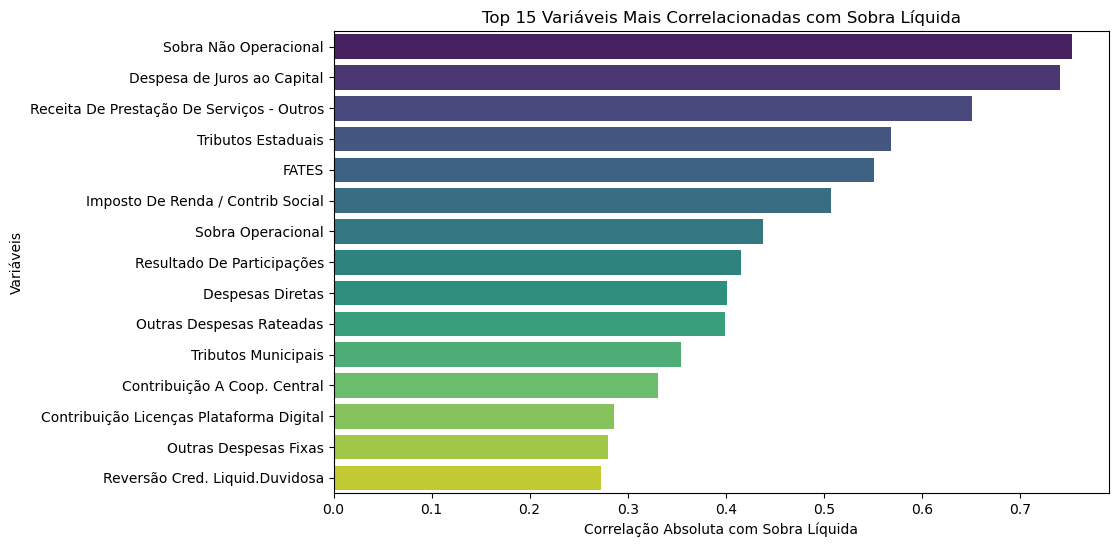

Prevendo variáveis correlacionadas:   0%|                                                       | 0/15 [00:00<?, ?it/s]22:05:20 - cmdstanpy - INFO - Chain [1] start processing
22:05:20 - cmdstanpy - INFO - Chain [1] done processing
Prevendo variáveis correlacionadas:   7%|███▏                                           | 1/15 [00:00<00:09,  1.45it/s]22:05:20 - cmdstanpy - INFO - Chain [1] start processing
22:05:21 - cmdstanpy - INFO - Chain [1] done processing
Prevendo variáveis correlacionadas:  13%|██████▎                                        | 2/15 [00:01<00:08,  1.54it/s]22:05:21 - cmdstanpy - INFO - Chain [1] start processing
22:05:21 - cmdstanpy - INFO - Chain [1] done processing
Prevendo variáveis correlacionadas:  20%|█████████▍                                     | 3/15 [00:01<00:07,  1.58it/s]22:05:21 - cmdstanpy - INFO - Chain [1] start processing
22:05:22 - cmdstanpy - INFO - Chain [1] done processing
Prevendo variáveis correlacionadas:  27%|████████████▌                  

Previsão para 2025 concluída e salva usando Prophet.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from tqdm import tqdm

# Carregar os dados do arquivo Excel
file_path = r"C:\Users\rossa\Desktop\Previsão\Teste.xlsx"
data = pd.read_excel(file_path, engine='openpyxl')

# Remover espaços extras dos nomes das colunas
data.columns = data.columns.str.strip()

# Calcular a correlação entre 'Sobra Líquida' e as demais colunas
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['Sobra Líquida'].abs().sort_values(ascending=False)
top_15_variables = correlation_with_target.index[1:16].tolist()

# Plotar gráfico de correlação
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target[top_15_variables], y=top_15_variables, palette="viridis")
plt.xlabel("Correlação Absoluta com Sobra Líquida")
plt.ylabel("Variáveis")
plt.title("Top 15 Variáveis Mais Correlacionadas com Sobra Líquida")
plt.show()

# Selecionar as 15 variáveis mais correlacionadas
selected_columns = ['Ano', 'Mês'] + top_15_variables

# Criar novo dataframe com as variáveis selecionadas
filtered_data = data[selected_columns + ['Sobra Líquida']].copy()

# Criar nova coluna de data e definir como índice
filtered_data['Date'] = pd.to_datetime(filtered_data['Ano'].astype(str) + '-' + filtered_data['Mês'].astype(str) + '-01')
filtered_data.set_index('Date', inplace=True)

# Criar datas futuras para previsão de 2025
future_dates = pd.date_range(start='2025-01-01', end='2025-12-01', freq='MS')
future_df = pd.DataFrame({'Date': future_dates})
future_df['Ano'] = future_df['Date'].dt.year
future_df['Mês'] = future_df['Date'].dt.month

# Prever valores das 15 variáveis correlacionadas para 2025 usando Prophet
with tqdm(total=len(top_15_variables), desc="Prevendo variáveis correlacionadas") as pbar:
    for col in top_15_variables:
        df_train = filtered_data[[col]].reset_index()
        df_train.columns = ['ds', 'y']
        
        model = Prophet()
        model.fit(df_train)
        
        future = pd.DataFrame({'ds': future_dates})
        forecast = model.predict(future)
        
        future_df[col] = forecast['yhat']
        pbar.update(1)

# Criar médias móveis e diferenças após prever variáveis
for col in top_15_variables:
    future_df[f'{col}_Moving_Avg'] = future_df[col].rolling(window=3).mean()
    future_df[f'{col}_Diff'] = future_df[col].diff()

# Preencher valores NaN
future_df.fillna(0, inplace=True)

# Criar conjunto final para prever 'Sobra Líquida' em 2025
train_data = filtered_data.copy()
df_train_final = train_data[['Sobra Líquida']].reset_index()
df_train_final.columns = ['ds', 'y']

# Treinar modelo Prophet para prever 'Sobra Líquida'
model = Prophet()
model.fit(df_train_final)

future = pd.DataFrame({'ds': future_dates})
forecast = model.predict(future)
future_df['Predicted_Sobra_Liquida'] = forecast['yhat']

# Salvar previsões de 2025
future_df.to_excel(r"C:\Users\rossa\Desktop\Previsão\Previsao2025-prophet.xlsx", index=False)

print("Previsão para 2025 concluída e salva usando Prophet.")
